# Baird's Counterexample
See Exercise 11.3
> Example and discussion from Section 11.2 of *Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.*

<img src="../imgs/baird.png" style="width: 60%;" />

In [1]:
import gymnasium as gym 
from mdp import baird
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import defaultdict
import pandas as pd 
import numpy as np 
import torch 

## Explore the state space

In [2]:
env = gym.make('BairdsCounterexample-v0')

def observe_states(env, policy: callable = None):
    env.reset()
    states = defaultdict(int)
    for _ in range(50_000):
        if policy is not None:
            action = policy(env)
        else:
            action = env.action_space.sample()
        state, _, _, _, _ = env.step(action)
        states[state] += 1
    S = pd.Series(states)
    return S

def policy(env):
    """ Calculates action taken by Baird's counterexample behavioral policy. """
    if np.random.rand() < (1 / env.observation_space.n):
        return 1 # Solid action
    else:
        return 0 # Dashed action

In [3]:
sample_policy = observe_states(env=env, policy=None)
baird_policy = observe_states(env=env, policy=policy)

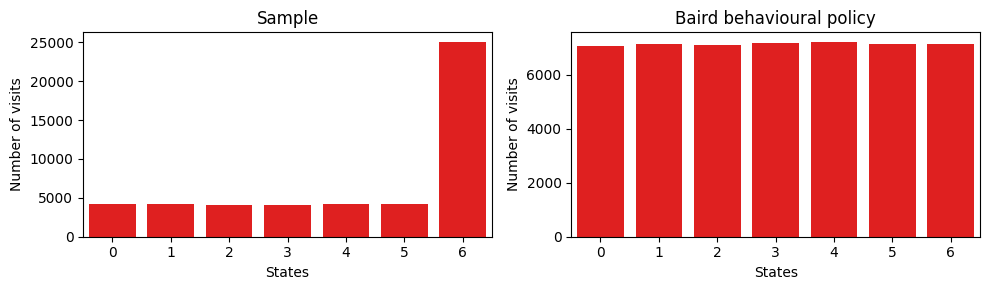

In [4]:
fig, ax = plt.subplots(figsize=(10, 3), ncols=2)
sns.barplot(x=sample_policy.index, y=sample_policy.values, ax=ax[0], color="r")
ax[0].set_xlabel('States')
ax[0].set_ylabel('Number of visits')
ax[0].set_title('Sample')
sns.barplot(x=baird_policy.index, y=baird_policy.values, ax=ax[1], color="r")
ax[1].set_xlabel('States')
ax[1].set_ylabel('Number of visits')
ax[1].set_title('Baird behavioural policy')
plt.tight_layout()
plt.show()


## Divergence of Q-learning
Q-learning steps
1. Initialize weights to a small random value.
2. Sample state, action, reward and next_state
3. Calculate Q target estimate using reward, next_state and maximal next action.
4. Calculate Q value estimate and it's gradient for the state and taken action.
5. Update weights so the Q value for the state and taken action to be closer to target.
6. Goto 2, unless the terminal condition is met.

In [5]:
def q_learning(env, n_steps, gamma = .99, alpha = 0.01, initial_w = None):
    def x(state):
        features = np.zeros(8)
        if state != 6:
            features[state] = 2
            features[-1] = 1
        else:
            features[state] = 1
            features[-1] = 2
        return torch.tensor(features, dtype=float, requires_grad=False)
    
    if initial_w is None:
        i_w = np.ones((8, 2))
    else:
        i_w = initial_w
    
    w = torch.tensor(i_w, dtype=float, requires_grad=True)
    
    def q(state, action):
        return x(state) @ w[:, action]
    
    def update(state, action, reward, s_prime):
        q_target = reward + gamma * max(q(s_prime, a) for a in range(env.action_space.n))
        q_value = q(state, action)
        delta = q_target - q_value
        q_value.backward()
        nonlocal w
        with torch.no_grad():
            w += alpha * delta * w.grad 
            w.grad.zero_()
    
    # init
    step = 1
    done = False
    history = {0: [], 1: []}
    state, _ = env.reset()
    
    # training
    while not done and step < n_steps:
        action = policy(env)
        s_prime, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        update(state, action, reward, s_prime)
        state = s_prime
        step += 1
        history[0].append(w[:, 0].tolist())
        history[1].append(w[:, 1].tolist())
    return history


In [6]:
initial_w = np.ones((8, 2))
initial_w[6] = np.array([10, 10]) # initialize such as in the book

H = q_learning(env=env, initial_w=initial_w, n_steps=5_000)
H0 = np.array(H[0])
H1 = np.array(H[1])

## Visualize parameters

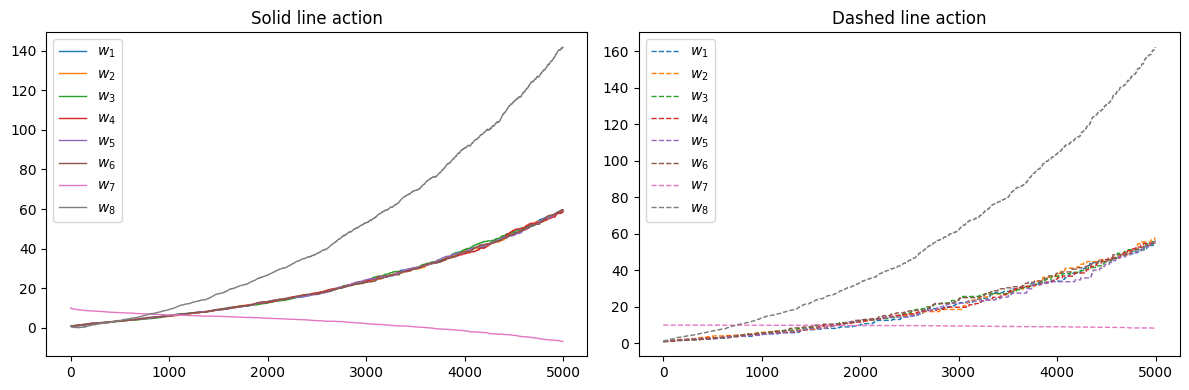

In [7]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
for i in range(8):
    p_label = f"$w_{i+1}$"
    ax[0].plot(H0[:,i], label=p_label, linestyle='-', linewidth=1)
    ax[1].plot(H1[:,i], label=p_label, linestyle='--', linewidth=1)
ax[0].set_title('Solid line action')
ax[1].set_title('Dashed line action')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

## SARSA
SARSA will not diverge in the linear setting because it's **on policy**. That means that the policy evaluated in the behavioral policy and not the best policy according to the estimation so far. 

In [8]:
def sarsa(env, n_steps, policy: callable, gamma = .99, alpha = 0.01, initial_w = None):
    """Note that we need a policy here to get a_prime"""
    def x(state):
        features = np.zeros(8)
        if state != 6:
            features[state] = 2
            features[-1] = 1
        else:
            features[state] = 1
            features[-1] = 2
        return torch.tensor(features, dtype=float, requires_grad=False)
    
    if initial_w is None:
        i_w = np.ones((8, 2))
    else:
        i_w = initial_w
    
    w = torch.tensor(i_w, dtype=float, requires_grad=True)
    
    def q(state, action):
        return x(state) @ w[:, action]
    
    def update(state, action, reward, s_prime):
        q_target = reward + gamma * q(s_prime, policy(env))
        q_value = q(state, action)
        delta = q_target - q_value
        q_value.backward()
        nonlocal w
        with torch.no_grad():
            w += alpha * delta * w.grad 
            w.grad.zero_()
    
    # init
    step = 1
    done = False
    history = {0: [], 1: []}
    state, _ = env.reset()
    
    # training
    while not done and step < n_steps:
        action = policy(env)
        s_prime, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        update(state, action, reward, s_prime)
        state = s_prime
        step += 1
        history[0].append(w[:, 0].tolist())
        history[1].append(w[:, 1].tolist())
    return history

In [9]:
initial_w = np.ones((8, 2))
initial_w[6] = np.array([10, 10]) # initialize such as in the book

H = sarsa(env=env, policy=policy, initial_w=initial_w, n_steps=5_000)
H0 = np.array(H[0])
H1 = np.array(H[1])

## Visualize parameters

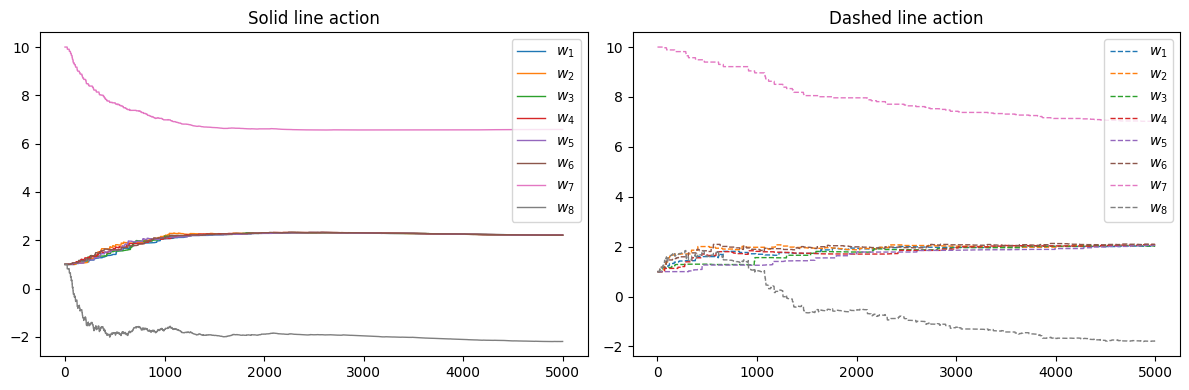

In [10]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
for i in range(8):
    p_label = f"$w_{i+1}$"
    ax[0].plot(H0[:,i], label=p_label, linestyle='-', linewidth=1)
    ax[1].plot(H1[:,i], label=p_label, linestyle='--', linewidth=1)
ax[0].set_title('Solid line action')
ax[1].set_title('Dashed line action')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()